In [117]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from Extract_Observation_Tem import extract_observation_tem
from Extract_Simulated_bt import extract_simulated_bt
print(tf.__version__)

2.4.1


In [118]:
# 获取模拟亮温数据
# 模拟亮温通过Fortran和IDL程序计算得到
Years = ['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
         #'2007', '2008', '2009', '2010'
        ]
train_data = extract_simulated_bt(Years)
train_data.drop(['22.235', '23.035', '23.835', '26.235', '30.000'], axis=1, inplace=True)
print(f'train_data shape is {train_data.shape}')

train_data shape is (7006, 7)


In [119]:

# summer = ['05', '06', '07', '08', '09', '10']
# for i in train_data.index:
#     if i[5:7] in summer:
#         train_data.drop(i, inplace=True)
# print(f'train_data shape is {train_data.shape}')

In [120]:
# 模拟亮温数据归一化
def norm(x):
    return (x - x.describe().transpose()['mean']) / x.describe().transpose()['std']
train_data = norm(train_data)

train_data = train_data.round(3)

In [121]:
# # 模拟亮温数据拆分为data和labels
# test_data = train_data.sample(frac=0.2, random_state=1)
# train_data.drop(test_data.index, inplace=True)
# train_data = train_data.sample(frac=1)
# print(f'train_data shape is {train_data.shape}')
# print(f'test_data shape is {test_data.shape}')
#
# print(train_data.head(5))

In [122]:
# 获取观测温度数据
train_labels = extract_observation_tem(Years)
# train_labels.drop(train_labels.columns[27:], axis=1, inplace=True)
# train_labels = norm(train_labels)
train_labels = train_labels.round(3)

print(f'train_labels shape is {train_labels.shape}')

train_labels shape is (7008, 47)


In [123]:
for i in train_labels.index:
    if(train_labels.loc[i].mean())<0:
        train_labels.drop(i, inplace=True)
        train_data.drop(i, inplace=True)
train_labels.shape

(6610, 47)

In [147]:
# for i in train_labels.index:
#     if i not in train_data.index:
#         train_labels.drop(i, inplace=True)
# for i in train_data.index:
#     if i not in train_labels.index:
#         train_data.drop(i, inplace=True)

def Cross_validation(x1, x2):
    for i in x1.index:
        if i not in x2.index:
            x1.drop(i, inplace=True)
    for i in x2.index:
        if i not in x1.index:
            x2.drop(i, inplace=True)

Cross_validation(train_data, train_labels)

In [125]:
# 观测温度数据拆分为data和labels
test_labels = train_labels.sample(frac=0.2, random_state=1)
train_labels.drop(test_labels.index, inplace=True)
train_labels = train_labels.sample(frac=1)
print(f'train_labels shape is {train_labels.shape}')
print(f'test_labels shape is {test_labels.shape}')

print(train_labels.head(5))

train_labels shape is (5286, 47)
test_labels shape is (1322, 47)
                  1965     2065     2165     2265     2365     2465     2565  \
1997/08/11:12  275.582  274.816  274.048  273.280  272.509  271.737  270.964   
2006/01/21:00  256.402  256.175  255.947  255.718  255.489  255.260  255.030   
2004/08/29:12  274.982  274.270  273.556  272.841  272.125  271.407  270.688   
1998/08/23:00  276.426  275.926  275.425  274.922  274.419  273.914  273.409   
2001/11/30:00  259.269  258.779  258.289  257.797  257.305  256.811  256.317   

                  2665     2765     2865  ...     9715     9965    10215  \
1997/08/11:12  270.189  269.413  268.635  ...  224.969  223.703  222.428   
2006/01/21:00  254.800  254.474  253.970  ...  217.708  216.892  216.069   
2004/08/29:12  269.967  269.245  268.521  ...  225.625  224.194  222.752   
1998/08/23:00  272.903  272.395  271.887  ...  226.757  225.208  223.648   
2001/11/30:00  255.821  255.325  254.655  ...  217.562  216.821  216.075  

In [126]:
# 拆分模拟亮温数据
test_data = train_data.loc[test_labels.index]
train_data = train_data.loc[train_labels.index]

print(f'train_data shape is {train_data.shape}')
print(f'test_data shape is {test_data.shape}')

print(train_data.head(5))

train_data shape is (5286, 7)
test_data shape is (1322, 7)
               51.250  52.280  53.850  54.940  56.660  57.290  58.800
1997/08/11:12   0.141   0.083   0.050   0.283   0.392   0.558   0.757
2006/01/21:00  -0.425  -0.341  -0.289  -0.095  -0.092  -0.094  -0.091
2004/08/29:12   0.306   0.207   0.149   0.335   0.446   0.616   0.821
1998/08/23:00   0.977   0.722   0.569   0.705   0.835   1.028   1.243
2001/11/30:00  -0.318  -0.254  -0.214   0.037   0.034   0.011  -0.026


In [130]:
def build_model():
    My_model = keras.Sequential([
        layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(23, activation='relu'),
        layers.Dense(len(train_labels.keys()))
    ])

    opt = tf.keras.optimizers.RMSprop(0.001)
    # tf.train.GradientDescentOptimizer(0.001)
    # tf.keras.optimizers.RMSprop(0.001)
    # tf.optimizers.Adam(1e-3)

    My_model.compile(loss='mse',
                     optimizer=opt,
                     metrics=['mae', 'mse']
                     )
    return My_model
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_22 (Dense)             (None, 23)                184       
_________________________________________________________________
dense_23 (Dense)             (None, 47)                1128      
Total params: 1,368
Trainable params: 1,368
Non-trainable params: 0
_________________________________________________________________


In [131]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=1500,
                    verbose=2,
                    validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1500
133/133 - 3s - loss: 56585.1172 - mae: 237.0755 - mse: 56585.1172 - val_loss: 55814.1758 - val_mae: 235.4254 - val_mse: 55814.1758
Epoch 2/1500
133/133 - 0s - loss: 54141.7578 - mae: 231.7694 - mse: 54141.7578 - val_loss: 51705.7188 - val_mae: 226.1797 - val_mse: 51705.7188
Epoch 3/1500
133/133 - 0s - loss: 48439.7227 - mae: 218.6024 - mse: 48439.7227 - val_loss: 44548.3477 - val_mae: 208.7892 - val_mse: 44548.3477
Epoch 4/1500
133/133 - 0s - loss: 40227.0273 - mae: 197.6662 - mse: 40227.0273 - val_loss: 36368.1523 - val_mae: 184.8270 - val_mse: 36368.1523
Epoch 5/1500
133/133 - 0s - loss: 31455.0000 - mae: 170.3405 - mse: 31455.0000 - val_loss: 28464.3828 - val_mae: 154.3058 - val_mse: 28464.3828
Epoch 6/1500
133/133 - 0s - loss: 23652.5137 - mae: 139.1193 - mse: 23652.5137 - val_loss: 22311.8203 - val_mae: 124.8742 - val_mse: 22311.8203
Epoch 7/1500
133/133 - 0s - loss: 18088.7227 - mae: 115.8758 - mse: 18088.7227 - val_loss: 17803.7070 - val_mae: 106.1016 - val_mse: 178

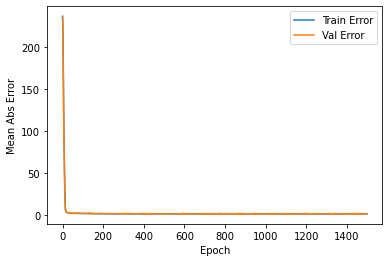

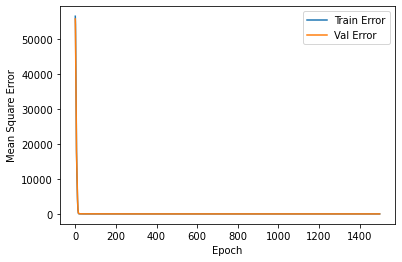

In [132]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    # plt.ylim([0, 10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    # plt.ylim([0, 70])
    plt.legend()
    plt.show()
plot_history(history)

In [133]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

42/42 [==============================] - 0s 2ms/step - loss: 5.2159 - mae: 1.6312 - mse: 5.2159
MAE:  1.63 
MSE:  5.22 
LOSS:  5.22 


In [134]:
r1 = 0
for i in range(test_data.shape[0]):
    r = np.corrcoef(model.predict(test_data[i:i + 1]), test_labels[i:i + 1])
    r1 += r[0, 1]
# print(r1/10)
print('相关系数 {:.4}'.format(r1 / test_data.shape[0]))

相关系数 0.9952


In [135]:
# for i in range(20):
flag = random.randrange(0, test_data.shape[0])
fig = plt.figure(figsize=(5, 10))
Height = [(int(i)-1965)/1000 for i in test_labels.columns]
X1 = model.predict(test_data[flag:flag + 1]).T
X2 = test_labels[flag:flag + 1].T
# plt.plot(np.abs(X1 - X2), Height)
# plt.plot(X1, Height)
# plt.plot(X2, Height)
# plt.xlabel('Temperatrure K')
# plt.ylabel('Altitude km')
# plt.title(test_data.index[flag])
# p = r'I:\Data\Personal_Data\graduation_project\Graduation_thesis\Atlas\Chapter6\\'
# plt.savefig(p+test_data.index[flag].replace('/', '')[:8]+'.png')
# plt.show()
print('相关系数{:.4}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
# print('平均偏差{:.4}'.format((X1-X2).mean().values))
# print(np.corcoef(X1.T,X2.T))
print(np.abs(np.mean(X1 - X2).round(4)))
print('\n')



相关系数0.9991
2006/06/29:00    0.223
dtype: float64




<Figure size 360x720 with 0 Axes>

In [159]:
data = extract_simulated_bt('2007')
data.drop(['22.235', '23.035', '23.835', '26.235', '30.000'], axis=1, inplace=True)
data = norm(data)
labels = extract_observation_tem('2007')

In [160]:
for i in labels.index:
    if labels.loc[i].mean()<0:
        labels.drop(i, inplace=True)
        data.drop(i, inplace=True)

Cross_validation(data, labels)
print(data.shape, labels.shape)


(631, 7) (631, 47)


In [161]:
# flag1 = random.randrange(0, test_data1.shape[0])
# fig = plt.figure(figsize=(5, 10))
# print(test_data1[flag:flag + 1])
# T1 = model.predict(test_data1[flag:flag + 1]).T
# T2 = test_labels1[flag:flag + 1].T
# print('相关系数{:.4}'.format(np.corrcoef(T1.T, T2.T)[0, 1]))
# print(np.abs(np.mean(T1 - T2).round(4)))
# plt.plot(np.abs(T1 - T2), Height)
# # plt.plot(T1, Height)
# # plt.plot(T2, Height)
# plt.show()

相关系数0.9992
2007/09/01:12    1.0614
dtype: float64




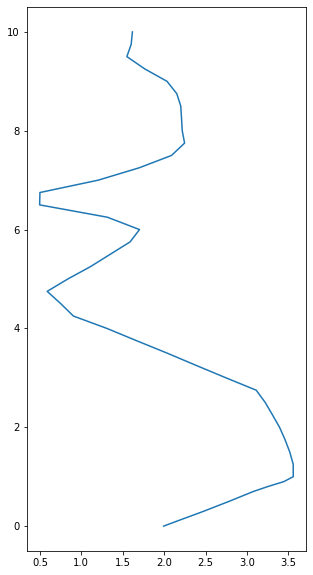

In [170]:
flag = random.randrange(0, data.shape[0])
fig = plt.figure(figsize=(5, 10))
Height = [(int(i)-1965)/1000 for i in labels.columns]
X1 = model.predict(data[flag:flag + 1]).T
X2 = labels[flag:flag + 1].T
plt.plot(np.abs(X1 - X2), Height)
# plt.plot(X1, Height)
# plt.plot(X2, Height)
# plt.xlabel('Temperatrure K')
# plt.ylabel('Altitude km')
# plt.title(test_data.index[flag])
# p = r'I:\Data\Personal_Data\graduation_project\Graduation_thesis\Atlas\Chapter6\\'
# plt.savefig(p+test_data.index[flag].replace('/', '')[:8]+'.png')
# plt.show()

print('相关系数{:.4}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
print(np.abs(np.mean(X1 - X2).round(4)))
print('\n')

In [171]:
# model.save(r'I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model0503')

INFO:tensorflow:Assets written to: I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model0503\assets
